# 1 - Imports

In [11]:
%reload_ext autoreload
%autoreload 2

In [63]:
import jaxquantum as jqt
import jaxquantum.circuits as jqtc
import jaxquantum.codes as jqtb
from jax import jit, grad, vmap
import jax.numpy as jnp
import numpy as np
from math import prod
import matplotlib.pyplot as plt

from tqdm import tqdm

import jax
import optax
import functools
import datetime
from jaxquantum import Qarray

plt.style.use('ggplot')

# 2 - Settings

In [55]:
settings = {
    "N": 100,
    "state": {
        "mode": "gkp",
        "delta": 0.4,
        "logical_state": "-y"
    },
    "N_large": 200,
}


if settings["state"]["mode"] == "gkp":
    delta = settings["state"]["delta"]
    gkp_qubit = jqtb.GKPQubit({"delta": delta, "N": settings["N"]})
    squeezing_level = 20*jnp.log10(jnp.exp(jnp.abs(jnp.log(delta))))
    settings["state"]["squeezing_level"] = squeezing_level
    target_state_cavity = gkp_qubit.basis[settings["state"]["logical_state"]]
    title = f"GKP Squeezing level: {squeezing_level:.2f} dB"


settings["target_state_cavity"] = target_state_cavity
settings["target_state"] = jqt.basis(2,0) ^ target_state_cavity

date_str = datetime.datetime.now().strftime("%Y%m%d_h%Hm%Ms%S")
settings["data_filename"] = f"data/{date_str}_{settings['state']['mode']}_state_prep.npz"

# 3 - Helpers

In [14]:
Ts = jnp.linspace(0, 500e-3, 30) #K
f = 4e9 #Hz
h = 6.62607015e-34 #Js
K = 1.380649e-23 #J/K
betas = h*f/K/Ts

In [48]:
def thermal(N: int, beta: float):
    """Thermal state.

    Args:
        N: Hilbert Space Size.
        beta: thermal state inverse temperature.

    Return:
        Thermal state.
    """
    
    return Qarray.create(jnp.where(jnp.isposinf(beta),
                     jqt.basis(N, 0).to_dm().data, 
                     jnp.diag(jnp.exp(-beta*jnp.linspace(0, N-1,N))))).unit()



def run_circuit(params, N, beta):
    gammas_x = 2*jnp.pi*params[0]
    gammas_y = 2*jnp.pi*params[1]
    betas_re = params[2]
    betas_im = params[3]

    betas = betas_re + 1j*betas_im
    
    reg = jqtc.Register([2,N])
    cirq = jqtc.Circuit.create(reg, layers=[])

    for i in range(len(gammas_x)):
        cirq.append(jqtc.Rx(gammas_x[i]), 0)
        cirq.append(jqtc.Ry(gammas_y[i]), 0)
        cirq.append(jqtc.CD(N, betas[i]), [0, 1])
        cirq.append(jqtc.Rx(jnp.pi), 0)
        
    measure=None
    
    if measure == 'x':
        cirq.append(jqtc.MX_plus(), 0, default_simulate_mode="kraus")
        cirq.append(jqtc.Ry(-jnp.pi/2), 0)
        initial_state = jqt.basis(2,0) ^ jqt.basis(N,0)
        res = jqtc.simulate(cirq, initial_state, mode="default")
        return res[-1][-1]/res[-1][-1].trace()
        
    if measure == 'z':
        cirq.append(jqtc.MZ_plus(), 0, default_simulate_mode="kraus")
        initial_state = jqt.basis(2,0) ^ jqt.basis(N,0)
        res = jqtc.simulate(cirq, initial_state, mode="default")
        return res[-1][-1]/res[-1][-1].trace()
        

    initial_state = jqt.basis(2,0).to_dm() ^ thermal(N, beta)
    res = jqtc.simulate(cirq, initial_state, mode="default")

    return res[-1][-1].unit()


def cf_tomography_circuit(state, beta, measure_real=True):
    N = state.dims[0][1]
    reg = jqtc.Register([2,N])
    cirq = jqtc.Circuit.create(reg, layers=[])

    cirq.append(jqtc.Ry(jnp.pi/2), 0)
    cirq.append(jqtc.CD(N, beta), [0,1])
    
    if measure_real:
        cirq.append(jqtc.Ry(jnp.pi/2), 0)
    else:
        cirq.append(jqtc.Rx(jnp.pi/2), 0)

    res = jqtc.simulate(cirq, state)
    final_state = res[-1][-1]
    sigmaz = jqt.sigmaz() ^ jqt.identity(N)
    sigmaz_exp = final_state.dag() @ sigmaz @ final_state
    return sigmaz_exp.data[0][0].real

def sim_cf(osc_state, betas_re=None, betas_im=None):
    if len(osc_state.dims[0]) == 1:
        if osc_state.is_dm():
            state = jqt.ket2dm(jqt.basis(2,0)) ^ osc_state
        else:
            state = jqt.basis(2,0) ^ osc_state
    else:
        state = osc_state

    # Plot CF
    betas_re = betas_re if betas_re is not None else jnp.linspace(-4,4, 101)
    betas_im = betas_re if betas_re is not None else  jnp.linspace(-4,4, 101)
    betas = betas_re.reshape(-1,1) + 1j*betas_im.reshape(1,-1)
    betas_flat = betas.flatten()

    cf_tomography_circuit_vmap = jit(vmap(lambda beta: cf_tomography_circuit(state, beta, measure_real=True)))
    tomo_res_real = cf_tomography_circuit_vmap(betas_flat)

    cf_tomography_circuit_vmap = jit(vmap(lambda beta: cf_tomography_circuit(state, beta, measure_real=False)))
    tomo_res_imag = cf_tomography_circuit_vmap(betas_flat)
    
    tomo_res_real = tomo_res_real.reshape(*betas.shape)
    tomo_res_imag = tomo_res_imag.reshape(*betas.shape)

    tomo_res = tomo_res_real + 1j*tomo_res_imag

    return tomo_res, betas_re, betas_im


def calculate_cf(osc_state, betas_re=None, betas_im=None):
    # Plot CF
    N = osc_state.dims[0][0]

    betas_re = betas_re if betas_re is not None else jnp.linspace(-4,4, 41)
    betas_im = betas_im if betas_im is not None else jnp.linspace(-4,4, 41)
    betas = betas_re.reshape(-1,1) + 1j*betas_im.reshape(1,-1)
    
    cf_vals = np.zeros((len(betas_re), len(betas_im)), dtype=jnp.complex64)
    for j in tqdm(range(len(betas_re))):
        for k in range(len(betas_im)):
            cf_vals[j,k] = jqt.overlap(jqt.displace(N, betas[j,k]), osc_state)
    return cf_vals, betas_re, betas_im


### (optionally) Load old params

In [129]:
data=np.load(r"/home/rolleri/repos/jaxquantum/experiments/circuit/data/20250702_h11m50s04_gkp_state_prep.npz", allow_pickle=True)
optimal_instructions = data["best_params"]

best_params = jnp.array([optimal_instructions[0], optimal_instructions[1], optimal_instructions[2], optimal_instructions[3]])

run_circuit_vmap = jax.vmap(run_circuit, in_axes=(None, None, 0), out_axes = 2)

prepared_states = run_circuit_vmap(best_params, 100, betas)

In [128]:
overlap_vmap = jax.vmap(jqt.overlap, in_axes=(0, None), out_axes=0)
overlaps = jnp.real(overlap_vmap(prepared_states, settings["target_state"]))

In [98]:
def temp2nbar(T):
    return np.where(T==0, 0, 1/(jnp.exp(h*f/K/T)-1))
def nbar2temp(nbar):
    return np.where(nbar==0, 0, h*f/K/jnp.log(1+1/nbar))

Text(0.5, 1.07, 'GKP $\\vert -Y \\rangle $ State Prep.; $\\Delta=0.4$')

/tmp/ipykernel_4027994/3851923396.py:4: RuntimeWarning: divide by zero encountered in divide
  return np.where(nbar==0, 0, h*f/K/jnp.log(1+1/nbar))


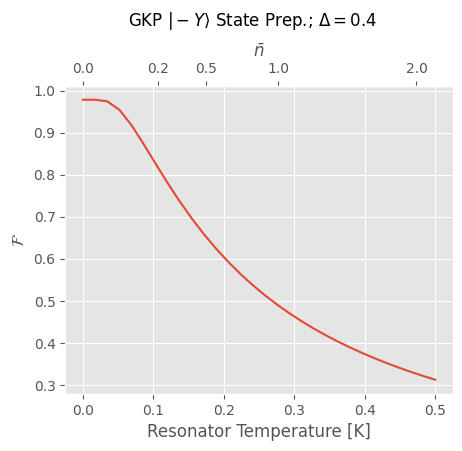

In [114]:
fig, ax = plt.subplots(1, figsize=(5, 4))
ax.plot(Ts, overlaps)
ax.set_xlabel("Resonator Temperature [K]")
ax.set_ylabel("$\mathcal{F}$")
ax.set_xlabel("Resonator Temperature [K]")
secax = ax.secondary_xaxis('top', functions=(temp2nbar, nbar2temp))
secax.set_ticks([0, 0.2, 0.5, 1, 2])
secax.set_xlabel("$\\bar{n}$")
fig.suptitle("GKP $\\vert -Y \\rangle $ State Prep.; $\\Delta=0.4$", y=1.07)

In [123]:
Qarray.create(prepared_states.data[7].shape)

(200, 200)

100%|█████████████████████████████████████████████████████████████████████████████████| 101/101 [00:48<00:00,  2.09it/s]


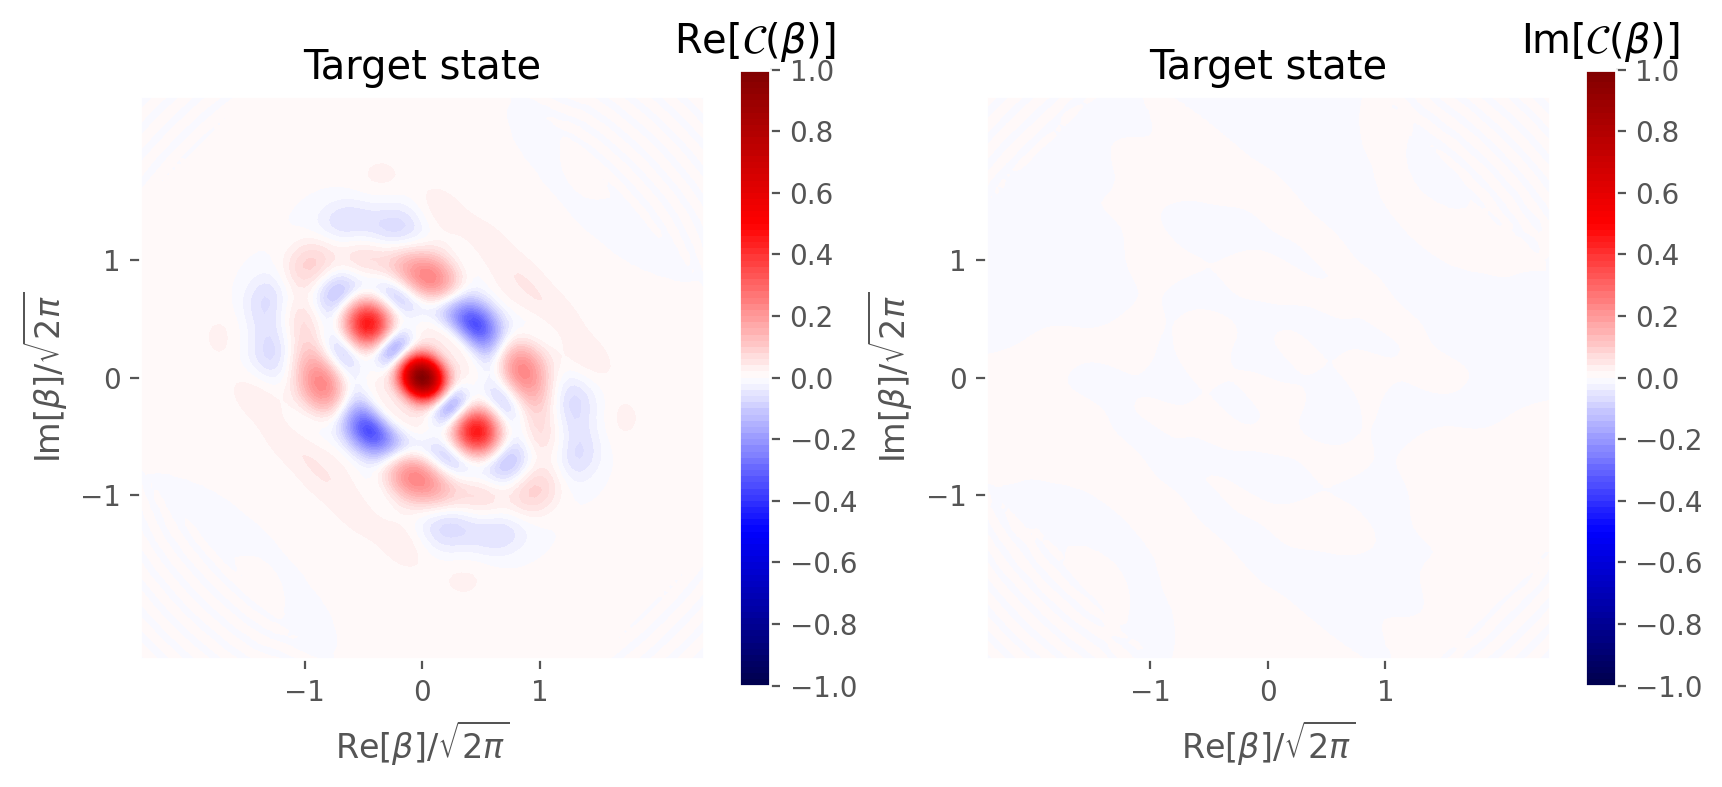

In [147]:
fig, axs = plt.subplots(1,2, dpi=200, figsize=(10,4))
betas_re = jnp.linspace(-6,6, 101)
betas_im = jnp.linspace(-6,6, 101)

cf_vals, _, _ = calculate_cf(Qarray.create(prepared_states.data[:, : , 25], dims=((2, 100), (2, 100))).ptrace(1), betas_re, betas_im)

for j, ax in enumerate((axs[0], axs[1])):
    vmin=-1
    vmax=1
    sf = 1/(jnp.sqrt(2*jnp.pi))

    if j == 0:
        cf_vals_plot = jnp.real(cf_vals)
        cbar_title = r"Re[$\mathcal{C}(\beta)$]"
    else:
        cf_vals_plot = jnp.imag(cf_vals)
        cbar_title = r"Im[$\mathcal{C}(\beta)$]"

    im = ax.contourf(betas_re*sf, betas_im*sf, cf_vals_plot.T, levels=np.linspace(vmin, vmax, 101), cmap="seismic", vmin=vmin, vmax=vmax)
    ax.set_aspect("equal", adjustable="box")
    ax.grid()

    ax.set_xticks([-1,0, 1])
    ax.set_yticks([-1,0, 1])
    ax.set_xlabel(r"Re[$\beta$]/$\sqrt{2\pi}$")
    ax.set_ylabel(r"Im[$\beta$]/$\sqrt{2\pi}$")

    cbar = plt.colorbar(im, ax=ax, orientation="vertical")
    cbar.ax.set_title(cbar_title)
    cbar.ax.set_yticks(np.linspace(-1, 1, 11))

    ax.set_title(r"Target state")

In [156]:
traced_state = Qarray.create(prepared_states.data[:, : , 7], dims=((2, 100), (2, 100))).ptrace(1)

In [157]:
jqt.overlap(jqtb.GKPQubit({"delta": delta, "N": settings["N"]}).common_gates["S_x_0"], traced_state)

Array(0.41112805+4.37150316e-15j, dtype=complex128)

In [158]:
jqt.overlap(jqtb.GKPQubit({"delta": delta, "N": settings["N"]}).common_gates["S_z_0"], traced_state)

Array(0.41258156+3.1918912e-15j, dtype=complex128)

### Plot

In [6]:
def qubit_phase(beta_squared, η0, η2, η4, η6, ξ2, ξ4, offset):
    beta_squared = np.abs(beta_squared)
    theta = ξ2 * beta_squared + ξ4 * beta_squared**2
    sx = np.cos(2*theta)
    sy = np.sin(2*theta)
    purity_scale_factor = (1 - (η0 + η2 *beta_squared + η4 * beta_squared**2 + η6 * beta_squared**3))
    return sx * purity_scale_factor + offset, sy * purity_scale_factor + offset

def purity_func(beta_squared, η0, η2, η4, η6, ξ2, ξ4, offset):
    sx, sy = qubit_phase(beta_squared, η0, η2, η4, η6, ξ2, ξ4, offset)
    return 0.5 * (1 + sx**2 + sy**2)

def calculate_envelope(betas_re, betas_im, fit_vals):
    betas_re_grid, betas_im_grid = jnp.meshgrid(betas_re, betas_im)
    betas_squared_grid = jnp.abs(betas_re_grid)**2 + jnp.abs(betas_im_grid)**2
    purity_vals = purity_func(betas_squared_grid, *fit_vals)
    envelope = 2*(purity_vals-0.5)
    return envelope


fit_vals = (0.39097432835648155,
 0.034291746251959555,
 -0.0010010145791953715,
 1.0867037992914275e-05,
 -0.04611114282106909,
 9.382815933549335e-06,
 0.07836293463518865)

Best parameters: 
 [[ 0.742146  0.010352  0.189244  0.758436  0.748159  0.2504    0.745491]
 [ 0.873653  0.749459  0.236892  0.569389  0.517529  0.994647  0.248023]
 [-0.875134  0.694451 -0.683801  0.953733 -0.949875 -0.219034 -0.036801]
 [ 0.850947  0.73491   0.708465  0.924257  0.947102 -0.222962  0.001797]]


Text(0.5, 1.02, '20250710_h16m39s07_gkp_state_prep.npz, $\\vert-y\\rangle, \\Delta=0.4000$, $M=None$, $N_B=7$, $\\beta=0.5$')

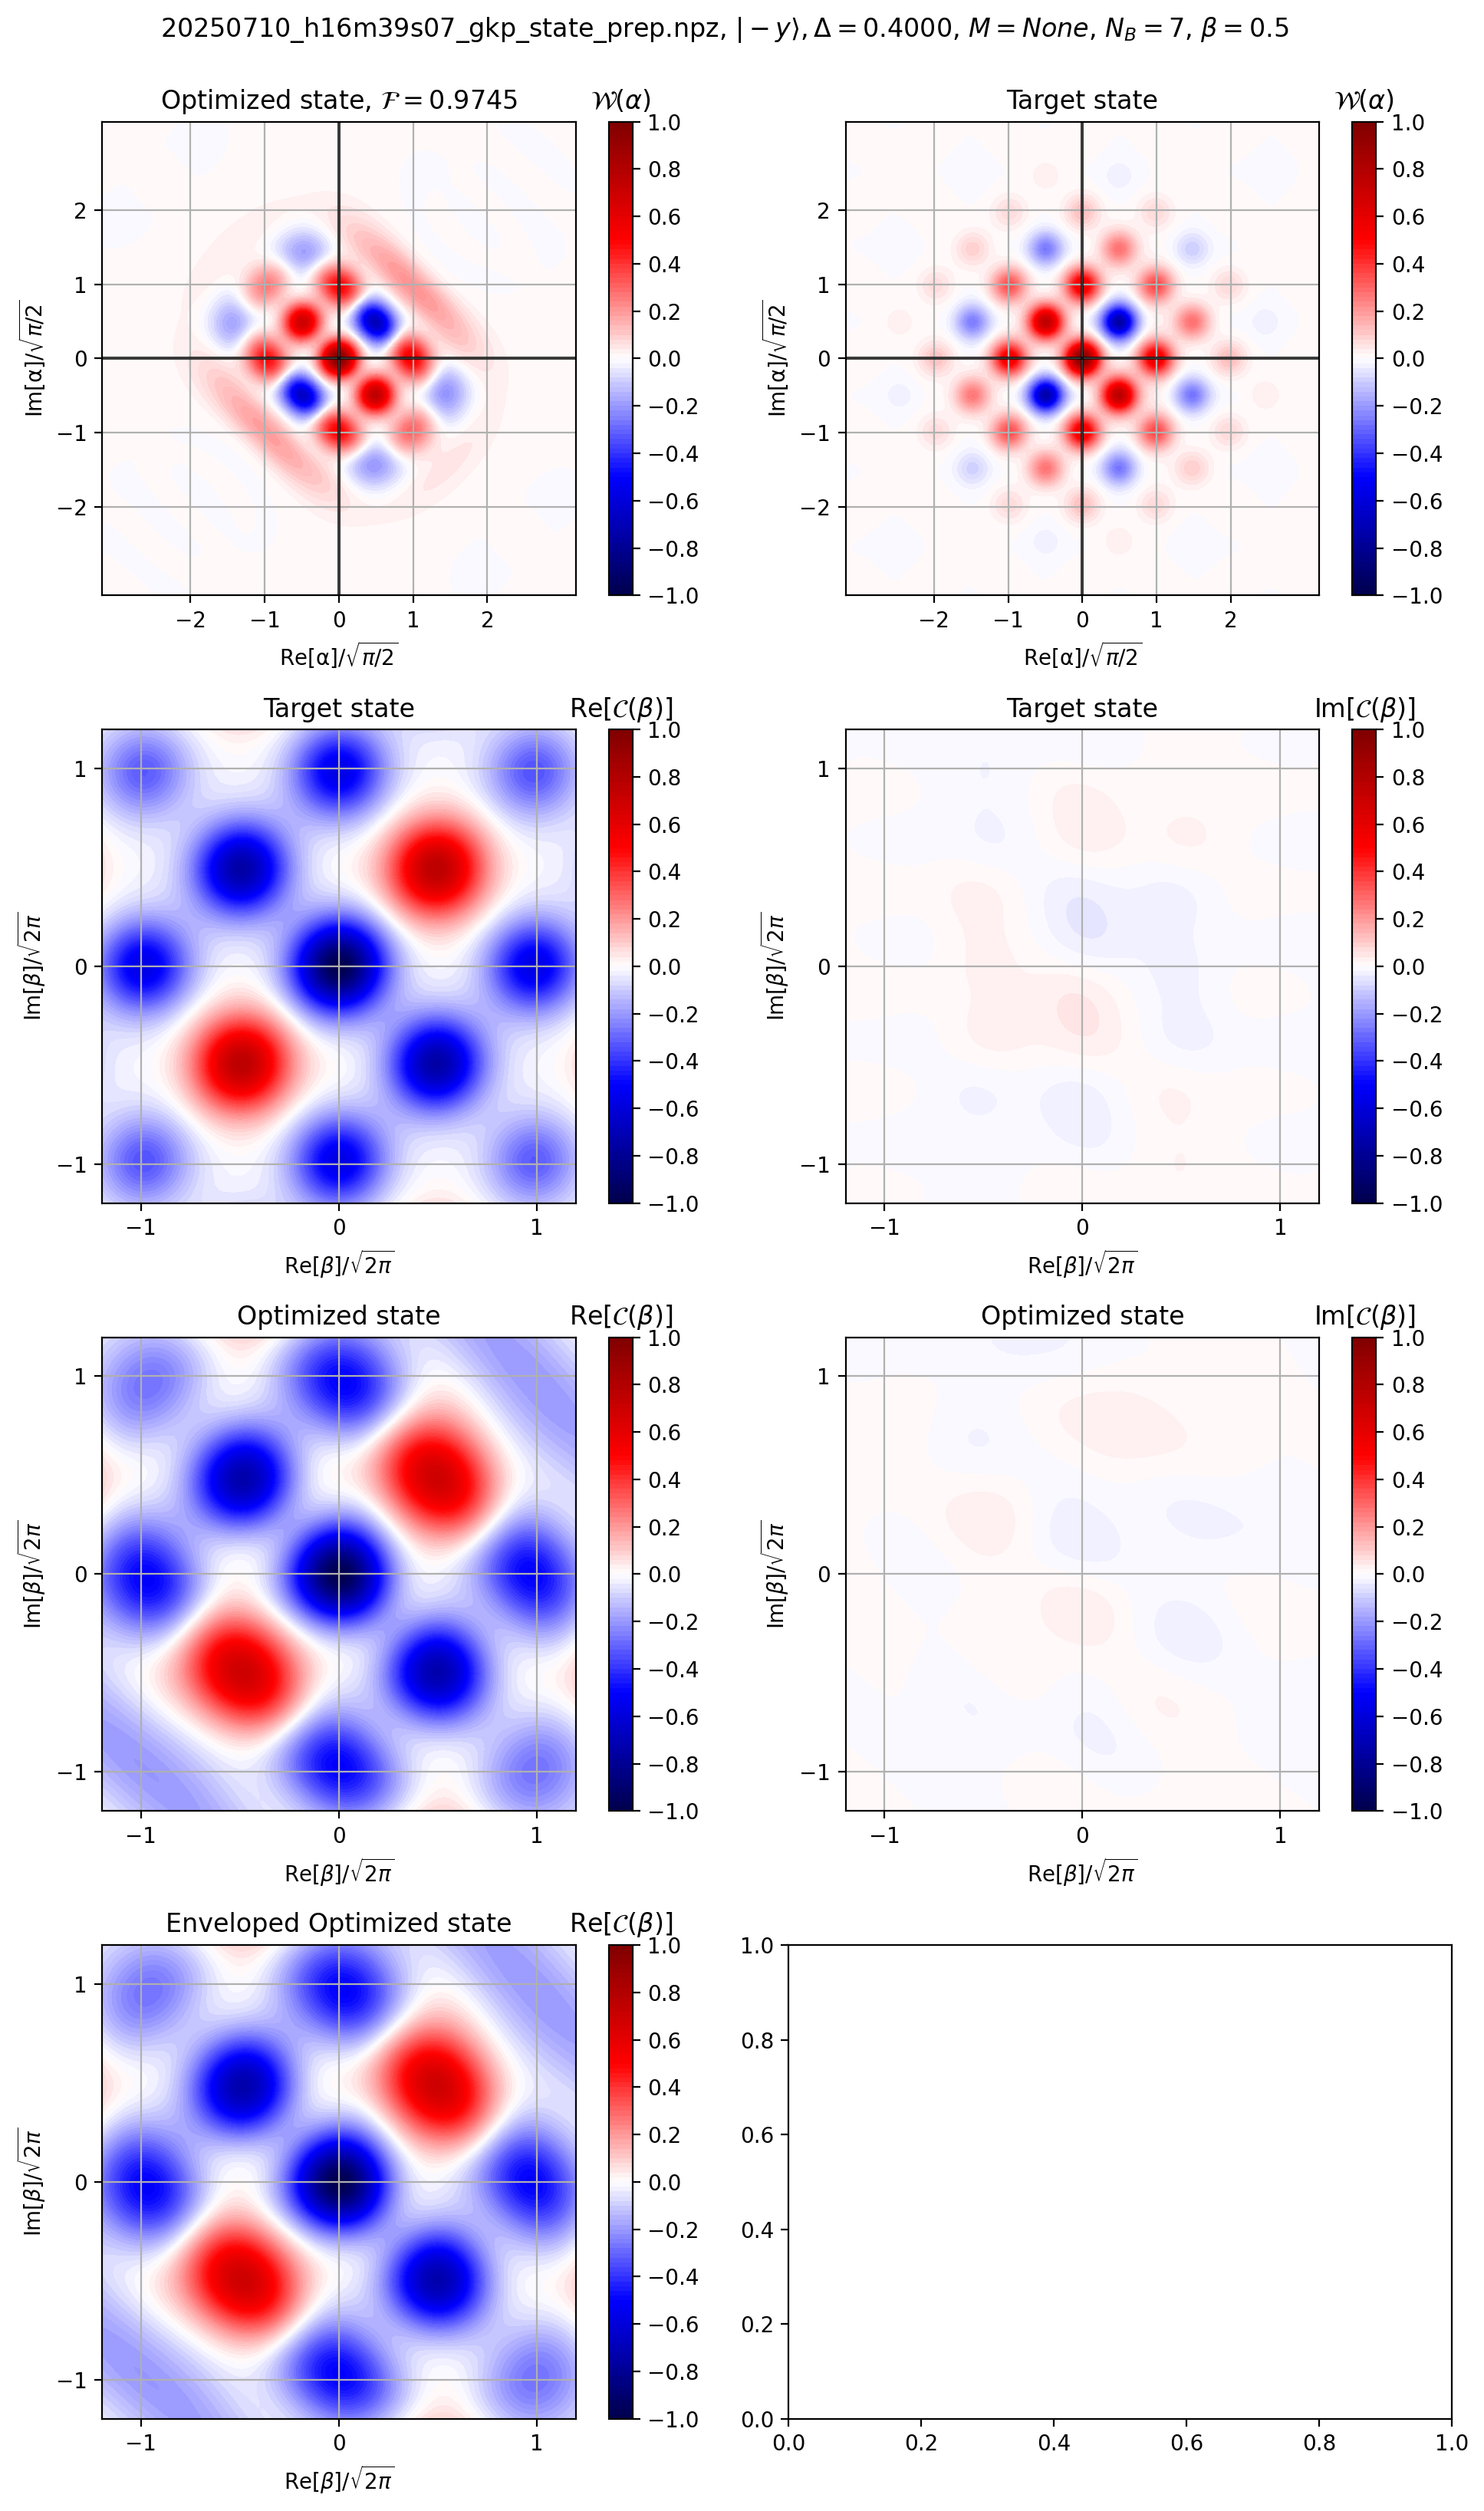

In [7]:
fig, axs = plt.subplots(4,2, dpi=200, figsize=(10,16))
axs = axs.flatten()
print("Best parameters: \n", best_params)

if settings["state"]["mode"] == "gkp":
    N_large = settings["N_large"]
    gkp_qubit_larger = jqtb.GKPQubit({"delta": settings["state"]["delta"], "N": N_large})
    target_state_larger = jqt.basis(2,0) ^ gkp_qubit_larger.basis[settings["state"]["logical_state"]]
 
prepared_state = run_circuit(best_params, N_large)
fid = jnp.real(jqt.overlap(target_state_larger, prepared_state))
pts = jnp.linspace(-4,4, 101)
ax, im = jqt.plot_wigner(jqt.ptrace(prepared_state,1), pts, ax=axs[0], axis_scale_factor=1/(jnp.sqrt(np.pi/2)))

ax.set_xticks([-2,-1, 0, 1,2])
ax.set_yticks([-2,-1, 0, 1,2])

ax.set_xlabel(r"Re[α]/$\sqrt{\pi/2}$")
ax.set_ylabel(r"Im[α]/$\sqrt{\pi/2}$")
# ax.set_title("Prepared state\n" + f"(N=50) Fidelity: {best_fid:.5f}\n" + f"(N={N}) Fidelity: {fid:.5f}")
ax.set_title(f"Optimized state, $\mathcal{{F}}={fid:.4f}$")


pts = jnp.linspace(-4,4, 101)
ax, im = jqt.plot_wigner(target_state_larger.ptrace(1), pts, ax=axs[1], axis_scale_factor=1/(jnp.sqrt(np.pi/2)))

ax.set_xticks([-2,-1, 0, 1,2])
ax.set_yticks([-2,-1, 0, 1,2])

ax.set_xlabel(r"Re[α]/$\sqrt{\pi/2}$")
ax.set_ylabel(r"Im[α]/$\sqrt{\pi/2}$")
ax.set_title("Target state")


betas_re = jnp.linspace(-3,3, 101)
betas_im = jnp.linspace(-3,3, 101)

cf_vals, _, _ = sim_cf(settings["target_state"], betas_re, betas_im)

for j, ax in enumerate((axs[2], axs[3])):
    vmin=-1
    vmax=1
    sf = 1/(jnp.sqrt(2*jnp.pi))

    if j == 0:
        cf_vals_plot = jnp.real(cf_vals)
        cbar_title = r"Re[$\mathcal{C}(\beta)$]"
    else:
        cf_vals_plot = jnp.imag(cf_vals)
        cbar_title = r"Im[$\mathcal{C}(\beta)$]"

    im = ax.contourf(betas_re*sf, betas_im*sf, cf_vals_plot.T, levels=np.linspace(vmin, vmax, 101), cmap="seismic", vmin=vmin, vmax=vmax)
    ax.set_aspect("equal", adjustable="box")
    ax.grid()

    ax.set_xticks([-1,0, 1])
    ax.set_yticks([-1,0, 1])
    ax.set_xlabel(r"Re[$\beta$]/$\sqrt{2\pi}$")
    ax.set_ylabel(r"Im[$\beta$]/$\sqrt{2\pi}$")

    cbar = plt.colorbar(im, ax=ax, orientation="vertical")
    cbar.ax.set_title(cbar_title)
    cbar.ax.set_yticks(np.linspace(-1, 1, 11))

    ax.set_title(r"Target state")

cf_vals, _, _ = sim_cf(prepared_state, betas_re, betas_im)

for j, ax in enumerate((axs[4], axs[5])):
    vmin=-1
    vmax=1
    sf = 1/(jnp.sqrt(2*jnp.pi))

    if j == 0:
        cf_vals_plot = jnp.real(cf_vals)
        cbar_title = r"Re[$\mathcal{C}(\beta)$]"
    else:
        cf_vals_plot = jnp.imag(cf_vals)
        cbar_title = r"Im[$\mathcal{C}(\beta)$]"

    im = ax.contourf(betas_re*sf, betas_im*sf, cf_vals_plot.T, levels=np.linspace(vmin, vmax, 101), cmap="seismic", vmin=vmin, vmax=vmax)
    ax.set_aspect("equal", adjustable="box")
    ax.grid()

    ax.set_xticks([-1,0, 1])
    ax.set_yticks([-1,0, 1])
    ax.set_xlabel(r"Re[$\beta$]/$\sqrt{2\pi}$")
    ax.set_ylabel(r"Im[$\beta$]/$\sqrt{2\pi}$")

    cbar = plt.colorbar(im, ax=ax, orientation="vertical")
    cbar.ax.set_title(cbar_title)
    cbar.ax.set_yticks(np.linspace(-1, 1, 11))

    ax.set_title(r"Optimized state")

envelope = calculate_envelope(betas_re, betas_im, fit_vals)

final_state = prepared_state
cf_vals, betas_re, betas_im = sim_cf(final_state, betas_re, betas_im)
#cf_vals = envelope * cf_vals

for j, ax in enumerate([axs[6]]):
    vmin=-1
    vmax=1
    sf = 1/(jnp.sqrt(2*jnp.pi))

    if j == 0:
        cf_vals_plot = jnp.real(cf_vals)
        cbar_title = r"Re[$\mathcal{C}(\beta)$]"
    else:
        cf_vals_plot = jnp.imag(cf_vals)
        cbar_title = r"Im[$\mathcal{C}(\beta)$]"

    im = ax.contourf(betas_re*sf, betas_im*sf, cf_vals_plot.T, levels=np.linspace(vmin, vmax, 101), cmap="seismic", vmin=vmin, vmax=vmax)
    ax.set_aspect("equal", adjustable="box")
    ax.grid()

    ax.set_xticks([-1,0, 1])
    ax.set_yticks([-1,0, 1])
    ax.set_xlabel(r"Re[$\beta$]/$\sqrt{2\pi}$")
    ax.set_ylabel(r"Im[$\beta$]/$\sqrt{2\pi}$")

    cbar = plt.colorbar(im, ax=ax, orientation="vertical")
    cbar.ax.set_title(cbar_title)
    cbar.ax.set_yticks(np.linspace(-1, 1, 11))

    ax.set_title(r"Enveloped Optimized state")

fig.tight_layout()
fig.suptitle(f"{date_str}_{settings['state']['mode']}_state_prep.npz, $\\vert{settings['state']['logical_state']}\\rangle, \\Delta={delta:.4f}$, $M={settings['measure']}$, $N_B={settings['blocks']}$, $\\beta={settings['reg_strength']}$", y=1.02)

In [8]:
np.savez(r"/home/rolleri/repos/jaxquantum/experiments/circuit/data/20250702_h11m50s04_cf_noenv_data_QCPR.npz", cf=-cf_vals_plot.T, betas_re=betas_re, betas_im=betas_im)

Text(0.5, 1.0, 'Enveloped Optimized state')

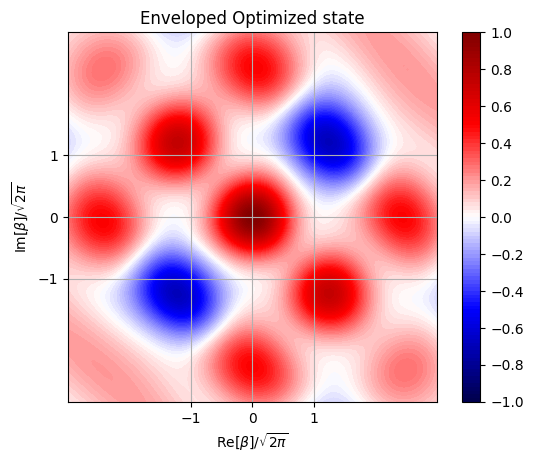

In [9]:
data=np.load(r"/home/rolleri/repos/jaxquantum/experiments/circuit/data/20250702_h11m50s04_cf_noenv_data_QCPR.npz", allow_pickle=True)
cf = data["cf"]
betas_re = data["betas_re"]
betas_im = data["betas_im"]

fig, ax = plt.subplots(1)

im = ax.contourf(betas_re, betas_im, cf, levels=np.linspace(-1, 1, 101), cmap="seismic")
ax.set_aspect("equal", adjustable="box")
ax.grid()

ax.set_xticks([-1,0, 1])
ax.set_yticks([-1,0, 1])
ax.set_xlabel(r"Re[$\beta$]/$\sqrt{2\pi}$")
ax.set_ylabel(r"Im[$\beta$]/$\sqrt{2\pi}$")

cbar = plt.colorbar(im, ax=ax, orientation="vertical")

cbar.ax.set_yticks(np.linspace(-1, 1, 11))

ax.set_title(r"Enveloped Optimized state")